# Expresso Churn Prediction Challenge
Made by team
- Kirill Prosvirin, Data Science
- Maksimilian Pavlov, Petroleum Engineering
- Ilya Basharov, Data Science

<img src="../images/expresso_logo.png" width="200px" align="center">

## Install requirement libs

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import libs

In [1]:
import os
import yaml
import gdown
import pandas as pd
import numpy as np
import os.path as osp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Default plot Params

params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (10, 10),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
plt.rcParams.update(params)

## Download the dataset

In [3]:
PROJECT_PATH = '../'
DATA_PATH = '../data'

with open(osp.join(PROJECT_PATH, 'data/links.yaml'), 'r') as stream:
    
    to_download = yaml.safe_load(stream)
    for filename, url in tqdm(to_download.items()):
        gdown.download(
            output=osp.join(PROJECT_PATH, filename),
            fuzzy=True,
            id=url,
            quiet=True,
        )

  0%|          | 0/5 [00:00<?, ?it/s]

## Read the dataset

In [4]:
data = {
    stage: pd.read_csv(osp.join(DATA_PATH, f'{stage}.csv'))
    for stage in ['Train', 'Test']
}

data['Train'].head(5)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,FATICK,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,NO,54,On net 200F=Unlimited _call24H,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,NaN,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,NaN,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,NO,17,On-net 1000F=10MilF;10d,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,DAKAR,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,NO,62,"Data:1000F=5GB,7d",11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,DAKAR,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,NO,11,Mixt 250F=Unlimited_call24H,2.0,0


## Using additional data about the country (Sinegal)

1) Population in persons by each area of the country. \
The main idea is more persons - more active users, more profitable for the company
2) Net rate of school attendance, education level \
The main idea is more education level, more trust in new technologies, more active users
3) Area by region \
The main idea is more area the less profitable for company. More data transmitters needed, more expensive maintenance
4) Total fertility rate \
Idea in more children in family, more family needs, more living expenses

## Read the additional data

In [5]:
ADDITIONAL_DATA_PATH = osp.join(DATA_PATH, 'additional_data')

additional_data = {}
for datatype in ['area', 'education', 'fertility', 'population']:
    with open(osp.join(ADDITIONAL_DATA_PATH, f'{datatype}.yaml'), 'r') as file:
        additional_data[datatype] = yaml.safe_load(file)

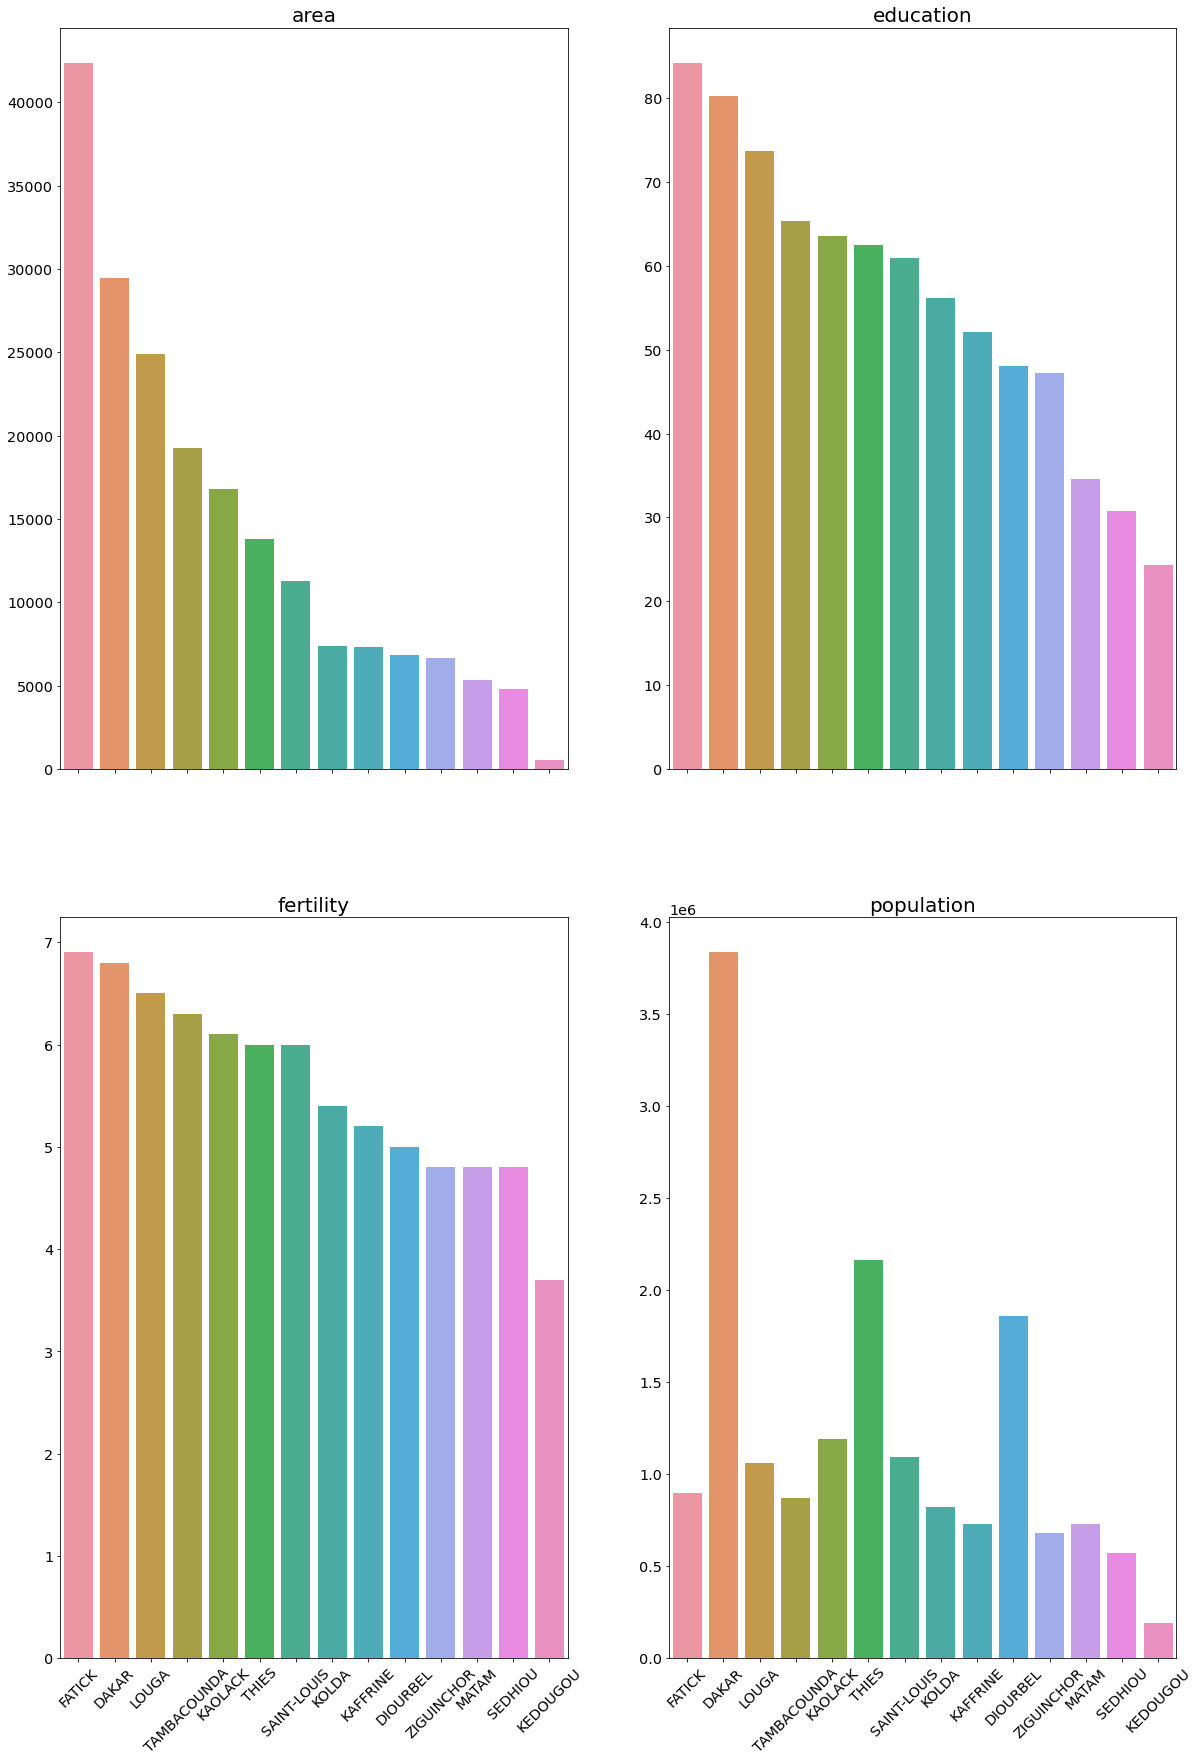

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(20, 30), sharex=True)
axs = axs.flatten()

for i, datatype in enumerate(additional_data):
    
    sns.barplot(
        x=list(additional_data[datatype].keys()),
        y=list(additional_data[datatype].values()),
        ax=axs[i]
    )
    axs[i].set_title(
        label=datatype,
        fontsize=20,
    )
    
    axs[i].xaxis.set_tick_params(rotation=45)

## Take a first look of the input data
Let's clean the data from obvious errors or unnecessary features.

In [7]:
unique_values = pd.DataFrame()

tasks = {
    'Unique': lambda col: f'{col.nunique()} / {len(col)}',
    'Nan': lambda col: f'{col.isna().sum()} / {len(col)}'
}

for task in tasks:
    for split in data:
        unique_values[f'{split} {task}/Total'] = \
            data[split].apply(tasks[task])
    
unique_values

,Train Unique/Total,Test Unique/Total,Train Nan/Total,Test Nan/Total
user_id,2154048 / 2154048,380127 / 380127,0 / 2154048,0 / 380127
REGION,14 / 2154048,14 / 380127,849299 / 2154048,149728 / 380127
TENURE,8 / 2154048,8 / 380127,0 / 2154048,0 / 380127
MONTANT,6540 / 2154048,2431 / 380127,756739 / 2154048,133055 / 380127
FREQUENCE_RECH,123 / 2154048,115 / 380127,756739 / 2154048,133055 / 380127
REVENUE,38114 / 2154048,23276 / 380127,726048 / 2154048,127373 / 380127
ARPU_SEGMENT,16535 / 2154048,10894 / 380127,726048 / 2154048,127373 / 380127
FREQUENCE,91 / 2154048,91 / 380127,726048 / 2154048,127373 / 380127
DATA_VOLUME,41550 / 2154048,21636 / 380127,1060433 / 2154048,187040 / 380127
ON_NET,9884 / 2154048,5914 / 380127,786675 / 2154048,138514 / 380127


## First look - Conclusions
1) Data has a lot of missings, it is a huge problem also for inference time. We should think about filling in the data or just drop it out
2) MRG and used_id features are not important - the value is the same for all columns. Solution - drop it.
3) Most likely, the target values (CHURN) are very unbalanced

In [8]:
# drop MRG, user_id feature

for split in data:
    data[split].drop(
        columns=['MRG', 'user_id'],
        inplace=True,
    )

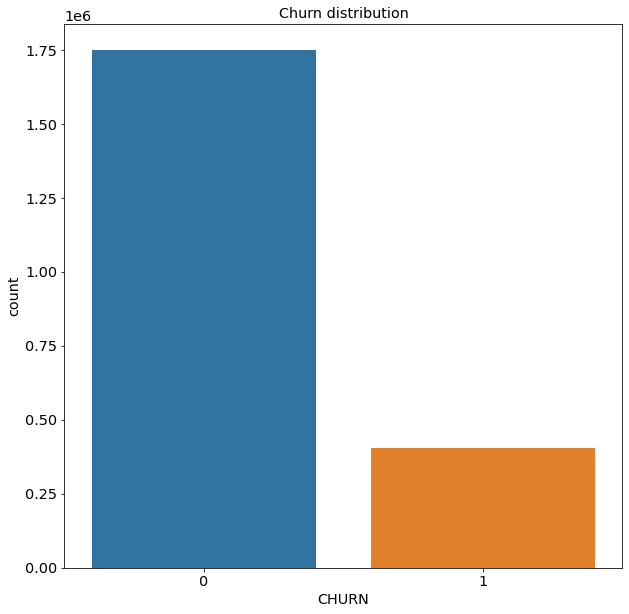

In [9]:
# target values are very unbalanced

sns.countplot(
    x='CHURN',
    data=data['Train'],
)
plt.title(
    label='Churn distribution',
);

## Go deeper to the data
Let's find the main dependences in the input data. For it:
1) Plot corellation map to find binary dependences
2) Find selective dependences and plot the distribution

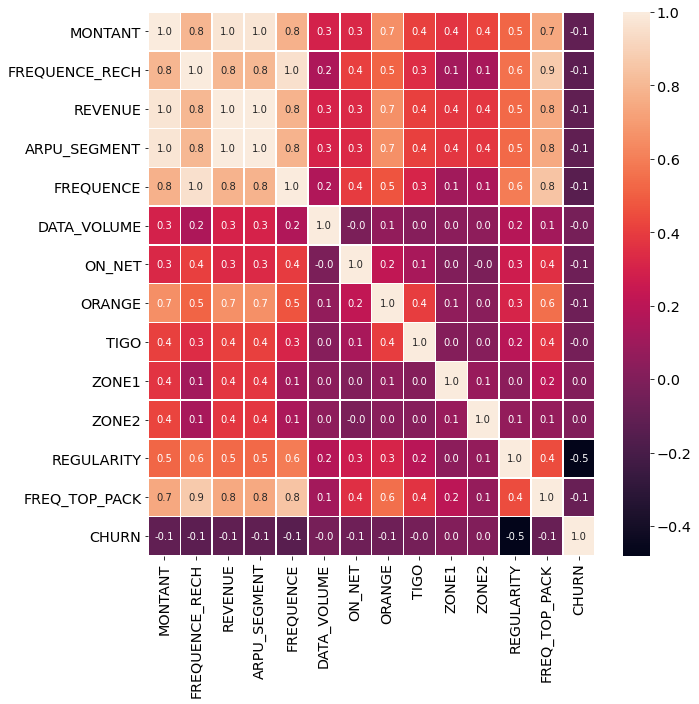

In [10]:
# plot the corellation map on train set

sns.heatmap(
    data=data['Train'].corr(),
    annot=True,
    linewidth=0.5,
    fmt='.1f',
);

We found out some interesting binary dependencies.

1) The more client has refilled the account - the more new packages he activaded
2) Also it depends on revenue - more revenue, more packages.

It seems like the higher the income, the more likely the customer will use the service. Let's check it farther.

3) It partially proven by top-up amount (Montant feature) and number of times the client has made an income (Frequence feature)

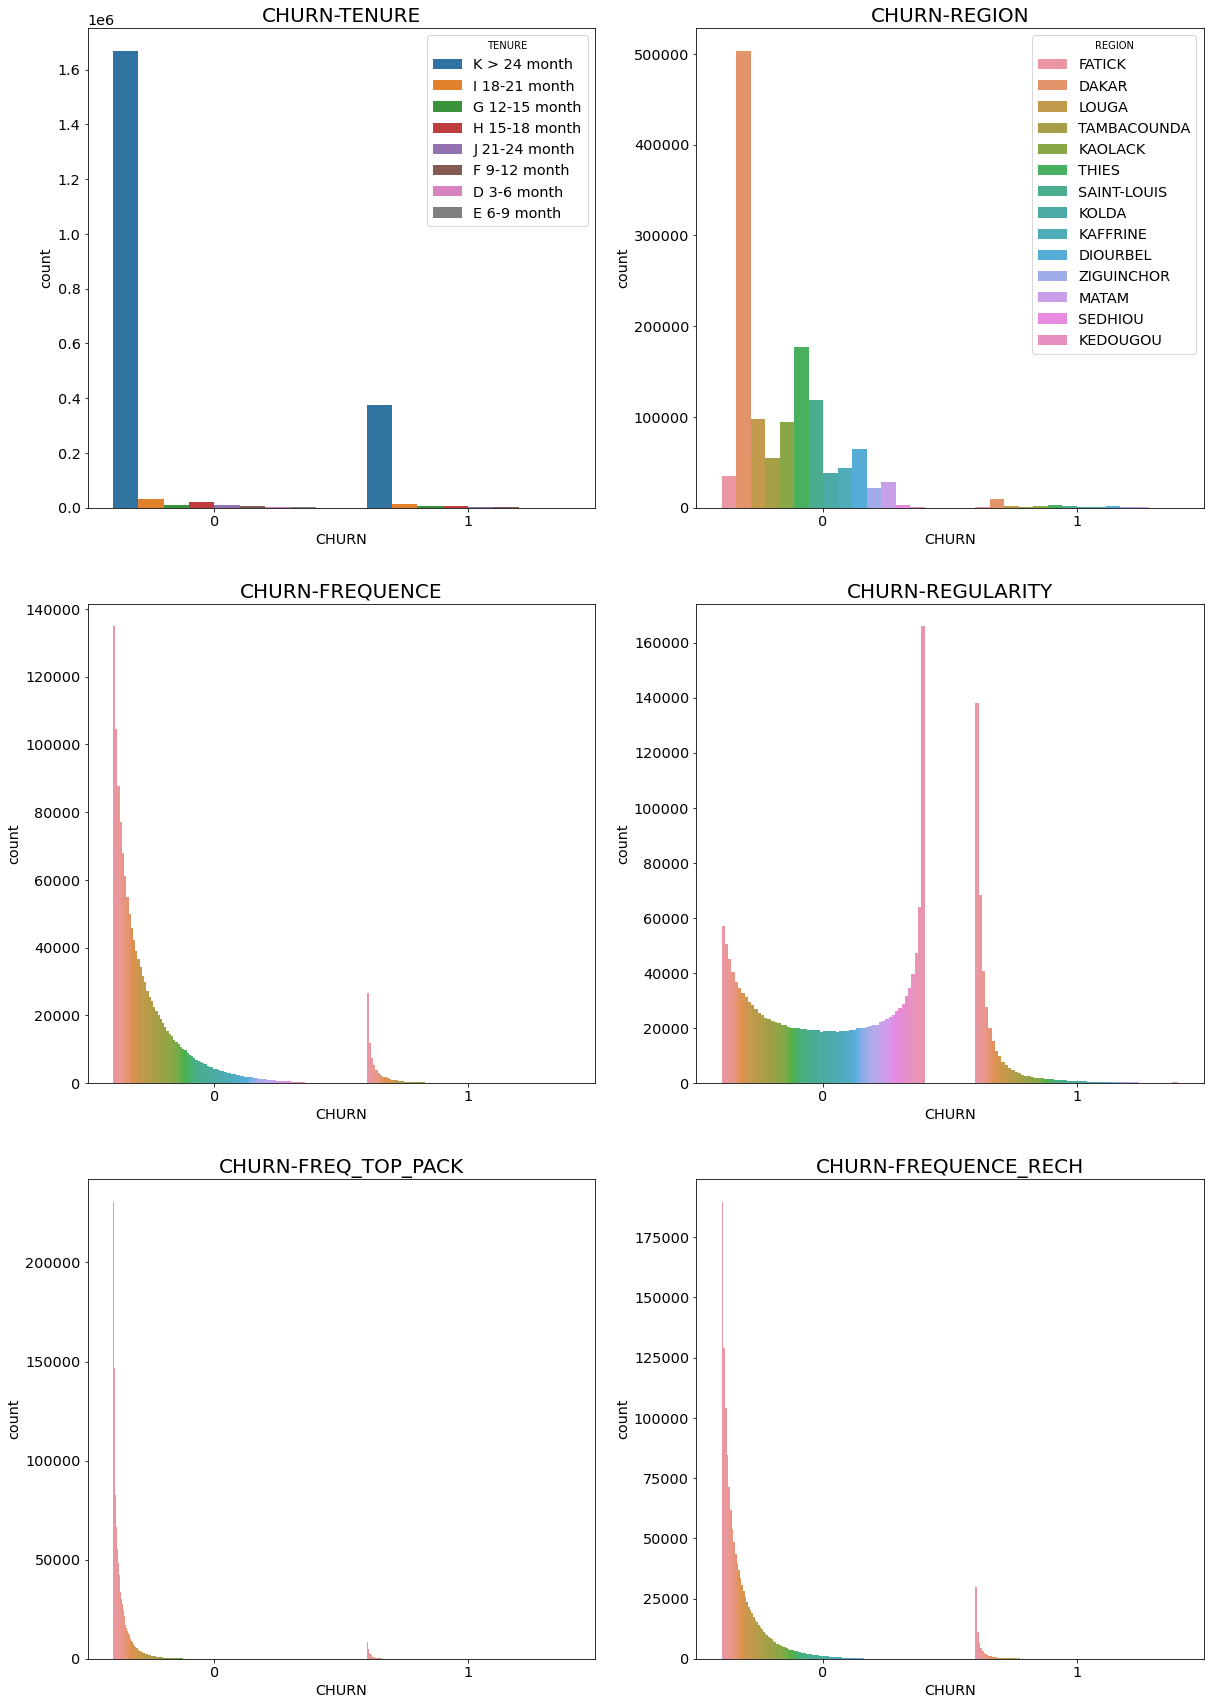

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(20, 30), )
axs = axs.flatten()

target = 'CHURN'
dependenses = [
    ('TENURE', True),
    ('REGION', True),
    ('FREQUENCE', False),
    ('REGULARITY', False),
    ('FREQ_TOP_PACK', False),
    ('FREQUENCE_RECH', False),
]

for i, (hue, legend) in enumerate(dependenses):
    
    sns.countplot(
        x=target,
        data=data['Train'],
        hue=hue,
        ax=axs[i],
    )
    
    axs[i].set_title(
        label=f'{target}-{hue}',
        fontsize=20,
    )
    
    if not legend:
        axs[i].get_legend().remove()

## Intermediate results

1) [CHURN-FREQ_TOP_PACK] Those who do not use communication packages leave more often. In turn, those who use actively remain. Maybe outgoing customers don't know about the benefits of packages.
2) [CHURN-REGION] Most of the outgoing clients are from Dakar. Most of the outgoing customers are from Dakar. In turn, there are more users in Dakar too. This is the result of population density.
3) [CHURN-TENURE] Unfortunately, most of the outgoing customers are still those who have been using the company for a long time. Whether this is due to revenue or a change in the company's policy is not yet clear.
4) [CHURN-REGULARITY] An interesting fact is that both an active client and an inactive one can stay (most likely it is a client of a specific purpose - tourist trips, etc.)

Let's take a deeper look at 3 point.

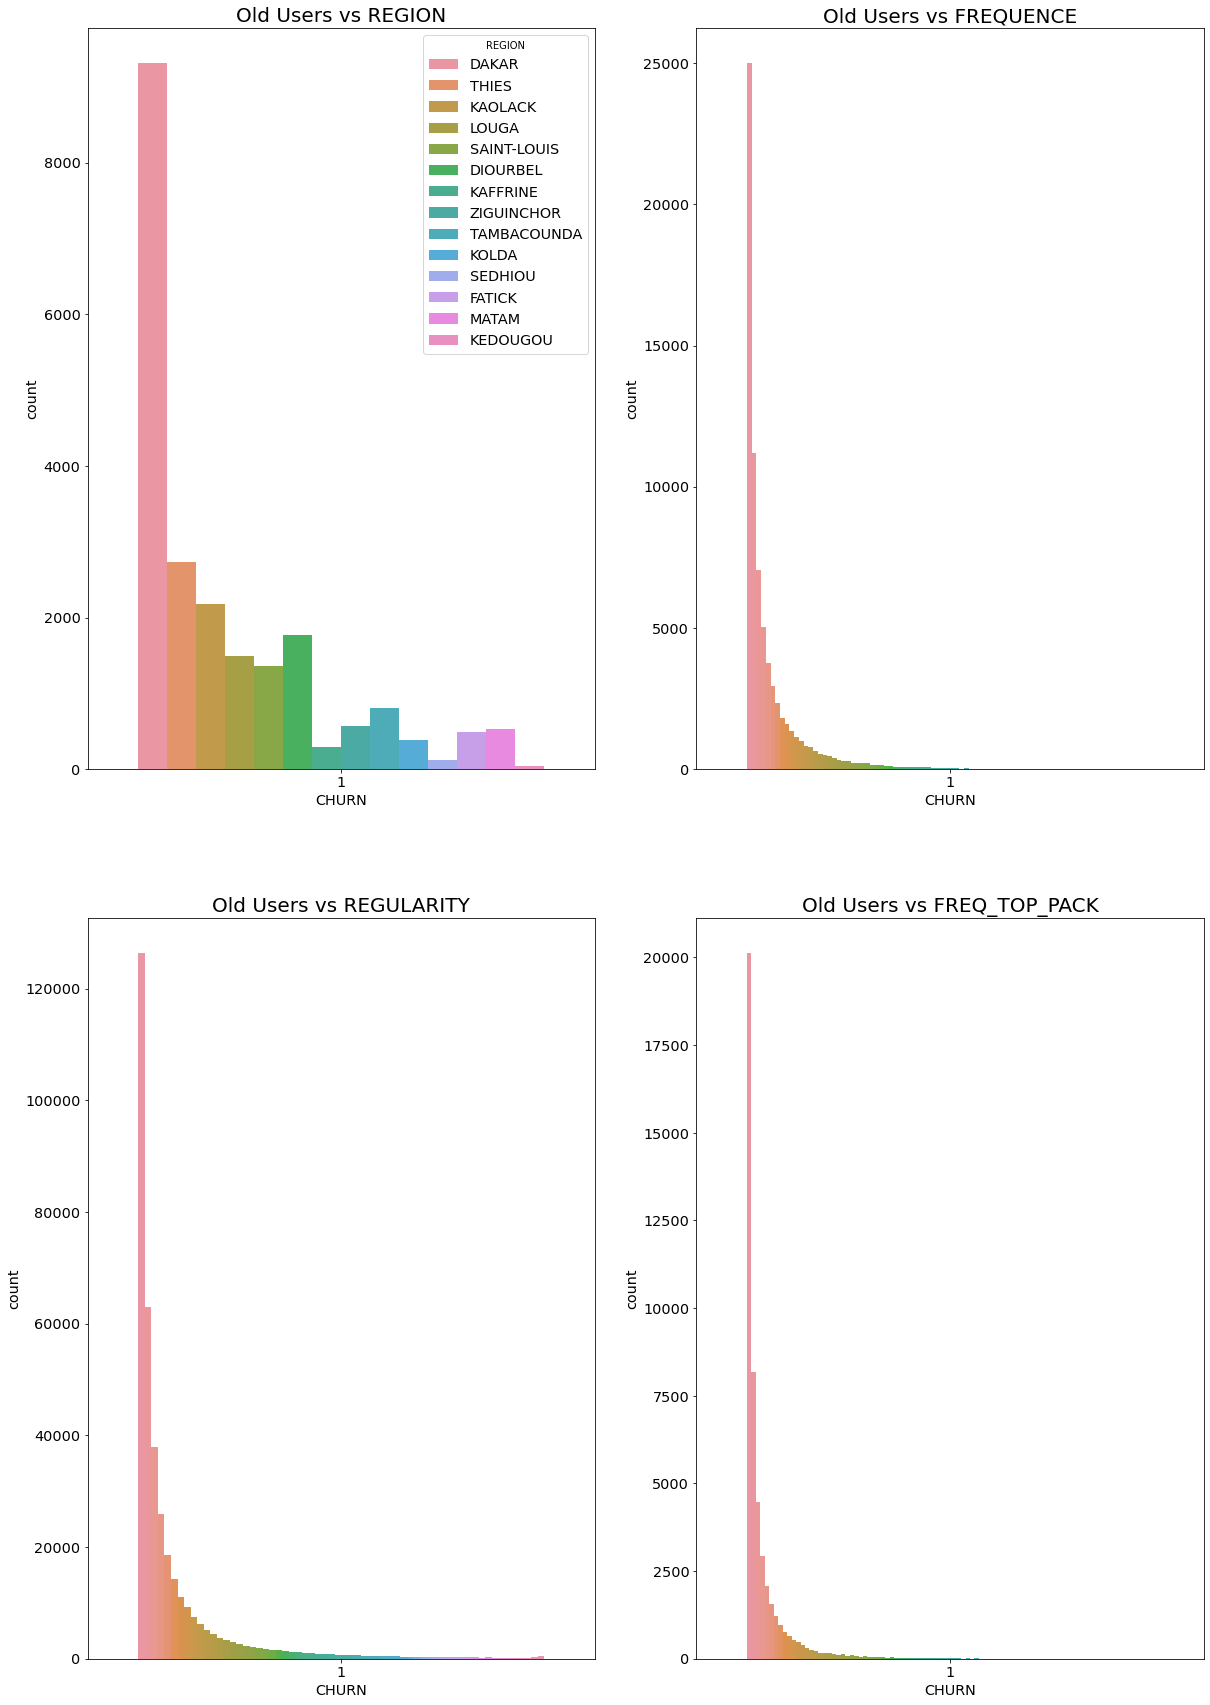

In [12]:
leave_and_old_users = data['Train'].query(
    '(CHURN==1) and (TENURE=="K > 24 month")'
)

fig, axs = plt.subplots(2, 2, figsize=(20, 30), )
axs = axs.flatten()

dependenses = [
    ('REGION', True),
    ('FREQUENCE', False),
    ('REGULARITY', False),
    ('FREQ_TOP_PACK', False),
]

for i, (hue, legend) in enumerate(dependenses):
    
    sns.countplot(
        x=target,
        data=leave_and_old_users,
        hue=hue,
        ax=axs[i],
    )
    
    axs[i].set_title(
        label=f'Old Users vs {hue}',
        fontsize=20,
    )
    
    if not legend:
        axs[i].get_legend().remove()

- all the old departed users from Dakar, perhaps a new interesting company has appeared there

## Missing values

1) If we talk about categorical features, then the missing values can be filled in with an additional categorical feature 'others'
2) If we talk about numerical features, it is very important to choose a filling method.

In [13]:
# create 'others' feature for some categorical features

fillna_others = ['TOP_PACK', 'REGION', ]
target = 'OTHERS'

for split in data:
    for fillna_type in fillna_others:
        data[split][fillna_type].fillna(
            value=target,
            inplace=True,
        )
        
# update additional data by mean of all regions for 'others'

for datatype in additional_data:
    additional_data[datatype][target] = \
        sum(additional_data[datatype].values()) / len(additional_data[datatype])

In [14]:
# encode nets values

net_features = ['ORANGE', 'TIGO', 'ZONE1', 'ZONE2']
for split in data:
    for net_feature in net_features:
        data[split][f'{net_feature}_encoded'] = data[split][net_feature].fillna(-1).apply(
            lambda x: 0 if x == -1 else 1
        )
        data[split][net_feature].fillna(
            data[split][net_feature].mean(),
            inplace=True,
        )

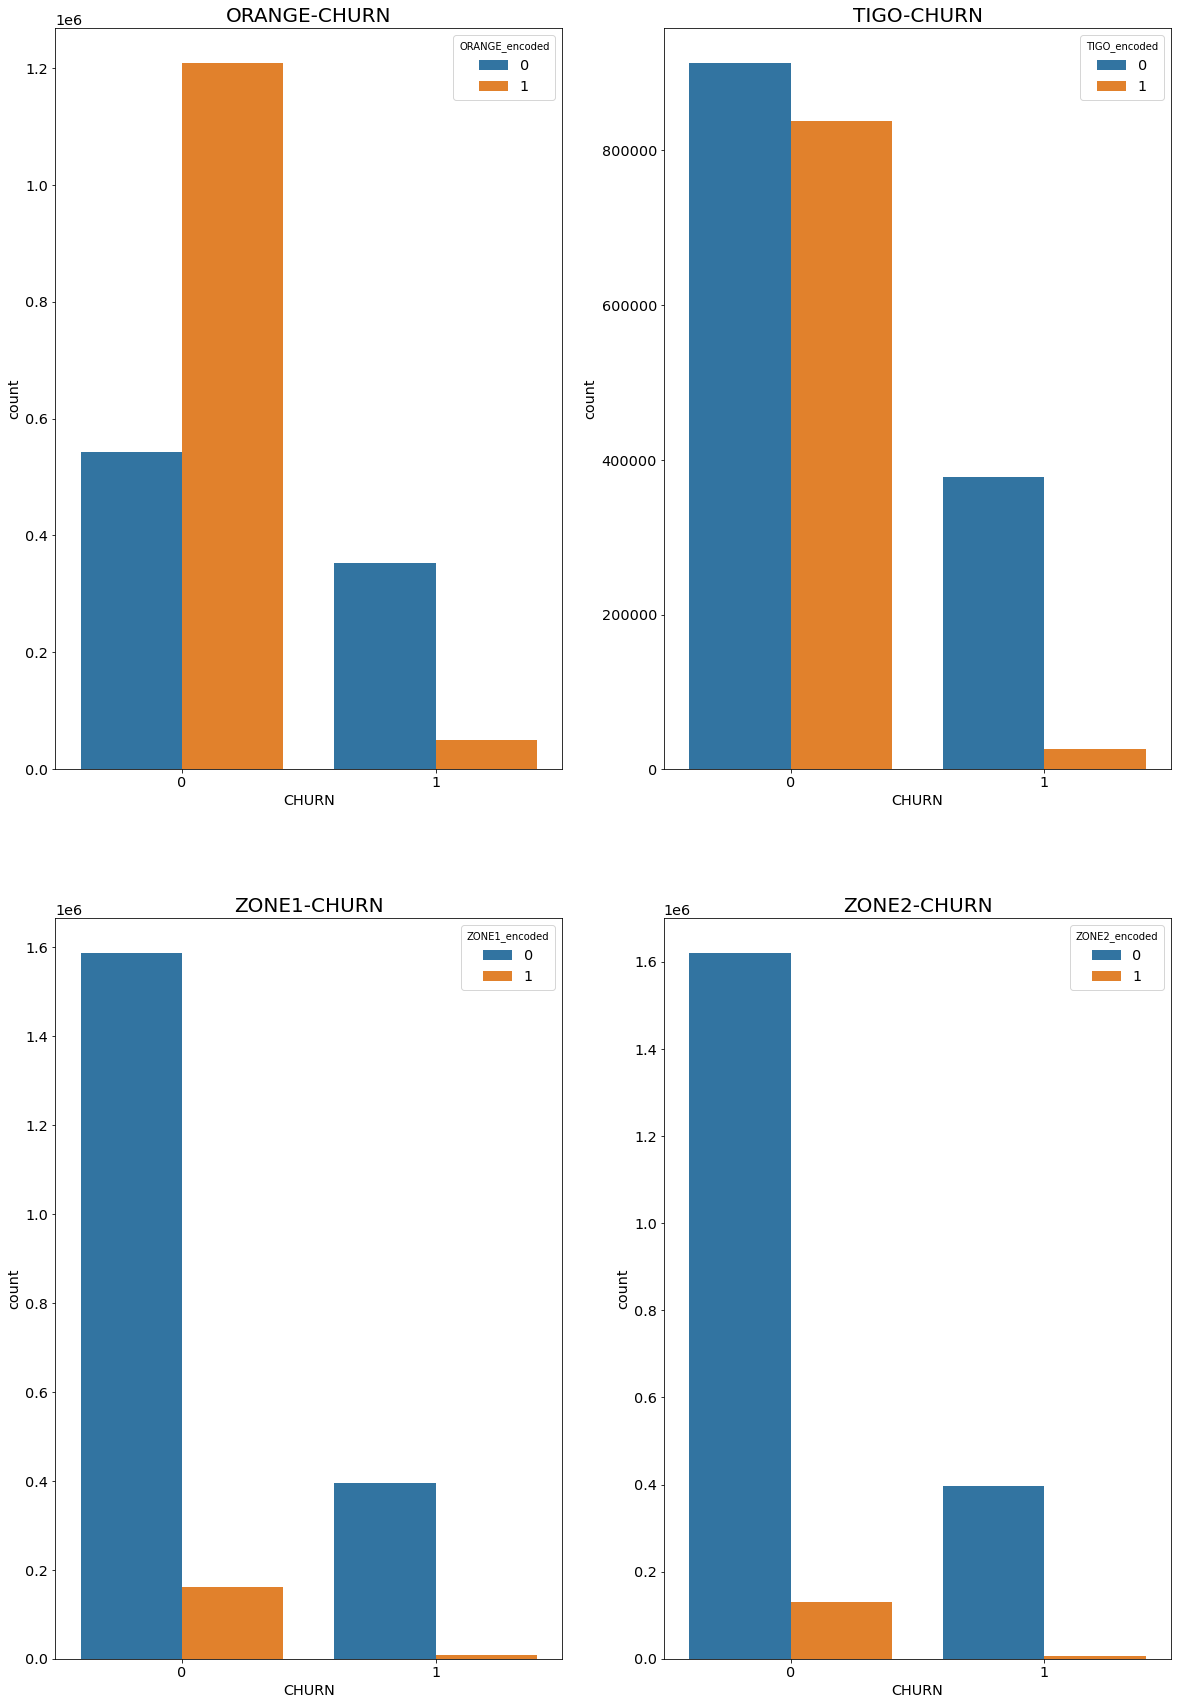

In [15]:
# let's visualize the output data

fig, axs = plt.subplots(2, 2, figsize=(20, 30), )
axs = axs.flatten()

for i, net_feature in enumerate(net_features):
    sns.countplot(
        x='CHURN',
        data=data['Train'],
        hue=f'{net_feature}_encoded',
        ax=axs[i],
    )
    axs[i].set_title(
        f'{net_feature}-CHURN',
        fontsize=20,
    )

Who call to ORANGE, most likely will say

## Check if input data has a noise

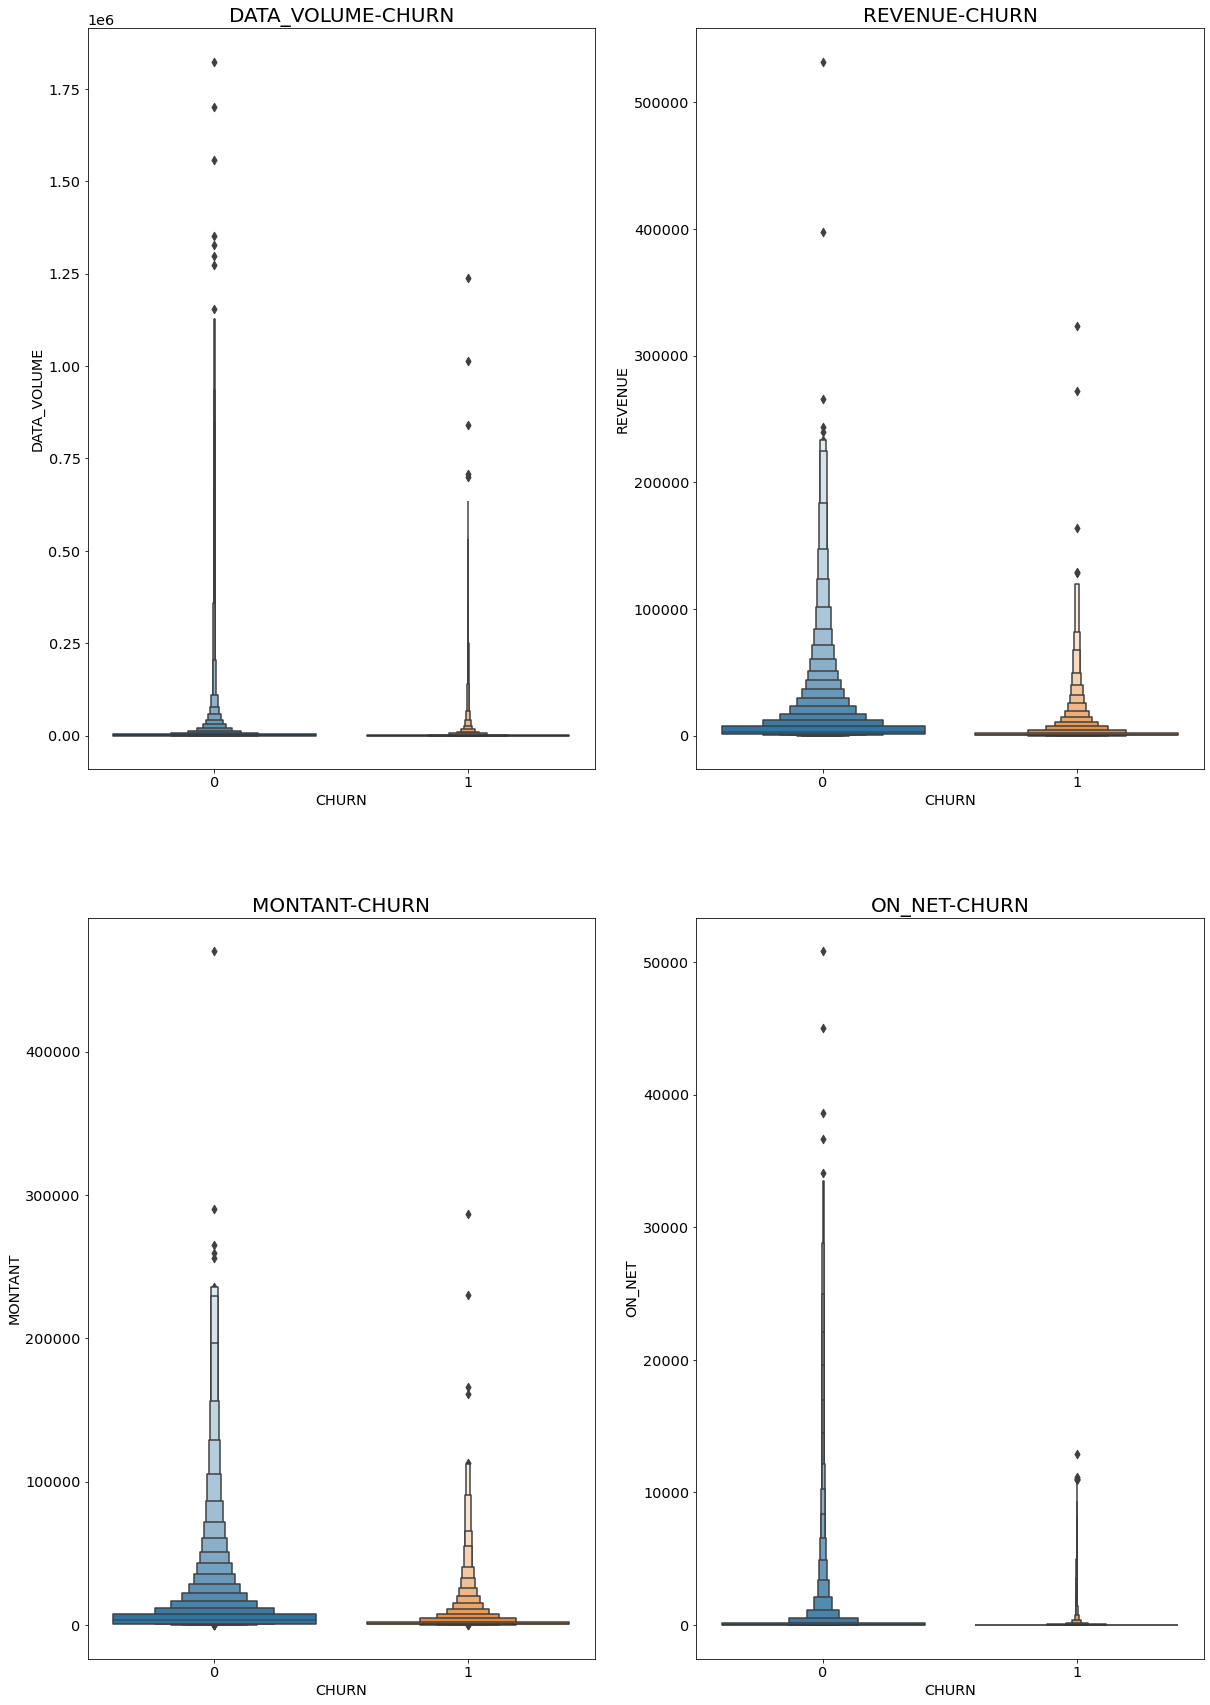

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 30), )
axs = axs.flatten()

noise_features = ['DATA_VOLUME', 'REVENUE', 'MONTANT', 'ON_NET']

for i, noise_feature in enumerate(noise_features):
    sns.boxenplot(
        x='CHURN',
        data=data['Train'],
        y=noise_feature,
        ax=axs[i],
        scale='area',
    )
    axs[i].set_title(
        f'{noise_feature}-CHURN',
        fontsize=20,
    )

Data has a huge noise, it would be better to use RobustScaler in future preprocessing.

## Feature Generation

In [17]:
def tenure(x):
    'function to encode the Tenure based on the lowest amount of month spent'
    # I think it's better to make a binary encoding. More than 24 month
    if x == 'K > 24 month':
        return 24
    elif x == 'H 15-18 month':
        return 15
    elif x == 'G 12-15 month':
        return 12
    elif x == 'J 21-24 month':
        return 21
    elif x == 'I 18-21 month':
        return 18
    elif x == 'E 6-9 month':
        return 6
    elif x == 'F 9-12 month':
        return 9
    elif x == 'D 3-6 month':
        return 3
    else:
        pass

In [18]:
def data_precessing(df: pd.DataFrame) -> pd.DataFrame:
    
    default_features = [
        'FREQUENCE', 'ON_NET',
        'MONTANT', 'REVENUE',
        'FREQUENCE_RECH',
        'ARPU_SEGMENT',
        'FREQ_TOP_PACK',
        'DATA_VOLUME',
    ]
    
    for default_feature in default_features:
        df[default_feature].fillna(
            0, inplace=True,
        )
        
    # create feature which will tell about the share of on_net calls among all which were made by user
    df['On_net_ratio'] = df['ON_NET'] / \
        (df['ON_NET']+df['ORANGE']+df['ZONE1']+df['ZONE2']+df['TIGO'] + 1e-3)
    df['On_net_ratio'].fillna(0, inplace=True)
    
    tenure_val = df['TENURE'].apply(tenure)
    
    df['Activeness'] = (tenure_val / (df['REGULARITY'] + 1e-3))
    df['Activeness'].fillna(0, inplace=True)
    
    df['Tenure_to_topup_frequency'] = (df['FREQUENCE_RECH'] / (tenure_val + 1e-3))
    df['Tenure_to_topup_frequency'].fillna(0, inplace=True)
    
    df['Income_per_topup_amount'] = (df['REVENUE'] / (df['MONTANT'] + 1e-3))
    df['Income_per_topup_amount'].fillna(0, inplace=True)
    
    df['Income_to_amount_ratio'] = (df['REVENUE'] / (df['MONTANT'] + 1e-3))
    df['Income_to_amount_ratio'].fillna(0, inplace=True)
    
    df['Income_left_after_top_up'] = df['REVENUE'] - df['MONTANT']
    
    df['Tenure_to_topup_frequency'] = (tenure_val / (df['FREQUENCE_RECH'] + 1e-3))
    df['Tenure_to_topup_frequency'].fillna(0, inplace=True)
    
    df['Income_in_90_days_per_revenue'] = (df['ARPU_SEGMENT'] / (df['REVENUE'] + 1e-3))
    df['Income_in_90_days_per_revenue'].fillna(0, inplace=True)
    
    df['income_per_region_fertility_amount'] = df[['REGION', 'REVENUE']].apply(
        lambda x: (x['REVENUE'] / (additional_data['fertility'][x['REGION']] + 1e-3)),
        axis=1,
    )
    
    df['income_per_region_fertility_amount'].fillna(0, inplace=True)
    
    df['area'] = df['REGION'].apply(
        lambda x: additional_data['area'][x],
    )
    df['fertility'] = df['REGION'].apply(
        lambda x: additional_data['fertility'][x]
    )
    df['population'] = df['REGION'].apply(
        lambda x: additional_data['population'][x]
    )
    df['education'] = df['REGION'].apply(
        lambda x: additional_data['education'][x]
    )
    prices = df.groupby('REGION')['REVENUE'].mean().to_dict()
    df['salary_amount'] = df[['REVENUE', 'REGION']].apply(
        lambda x: (x['REVENUE'] / (prices[x['REGION']] + 1e-3)),
        axis=1,
    )
    
    df['salary_amount'].fillna(0, inplace=True)
    
    return df

In [19]:
for split in data:
    data[split] = data_precessing(data[split])
    data[split].fillna(0, inplace=True)

## Visualize the final data

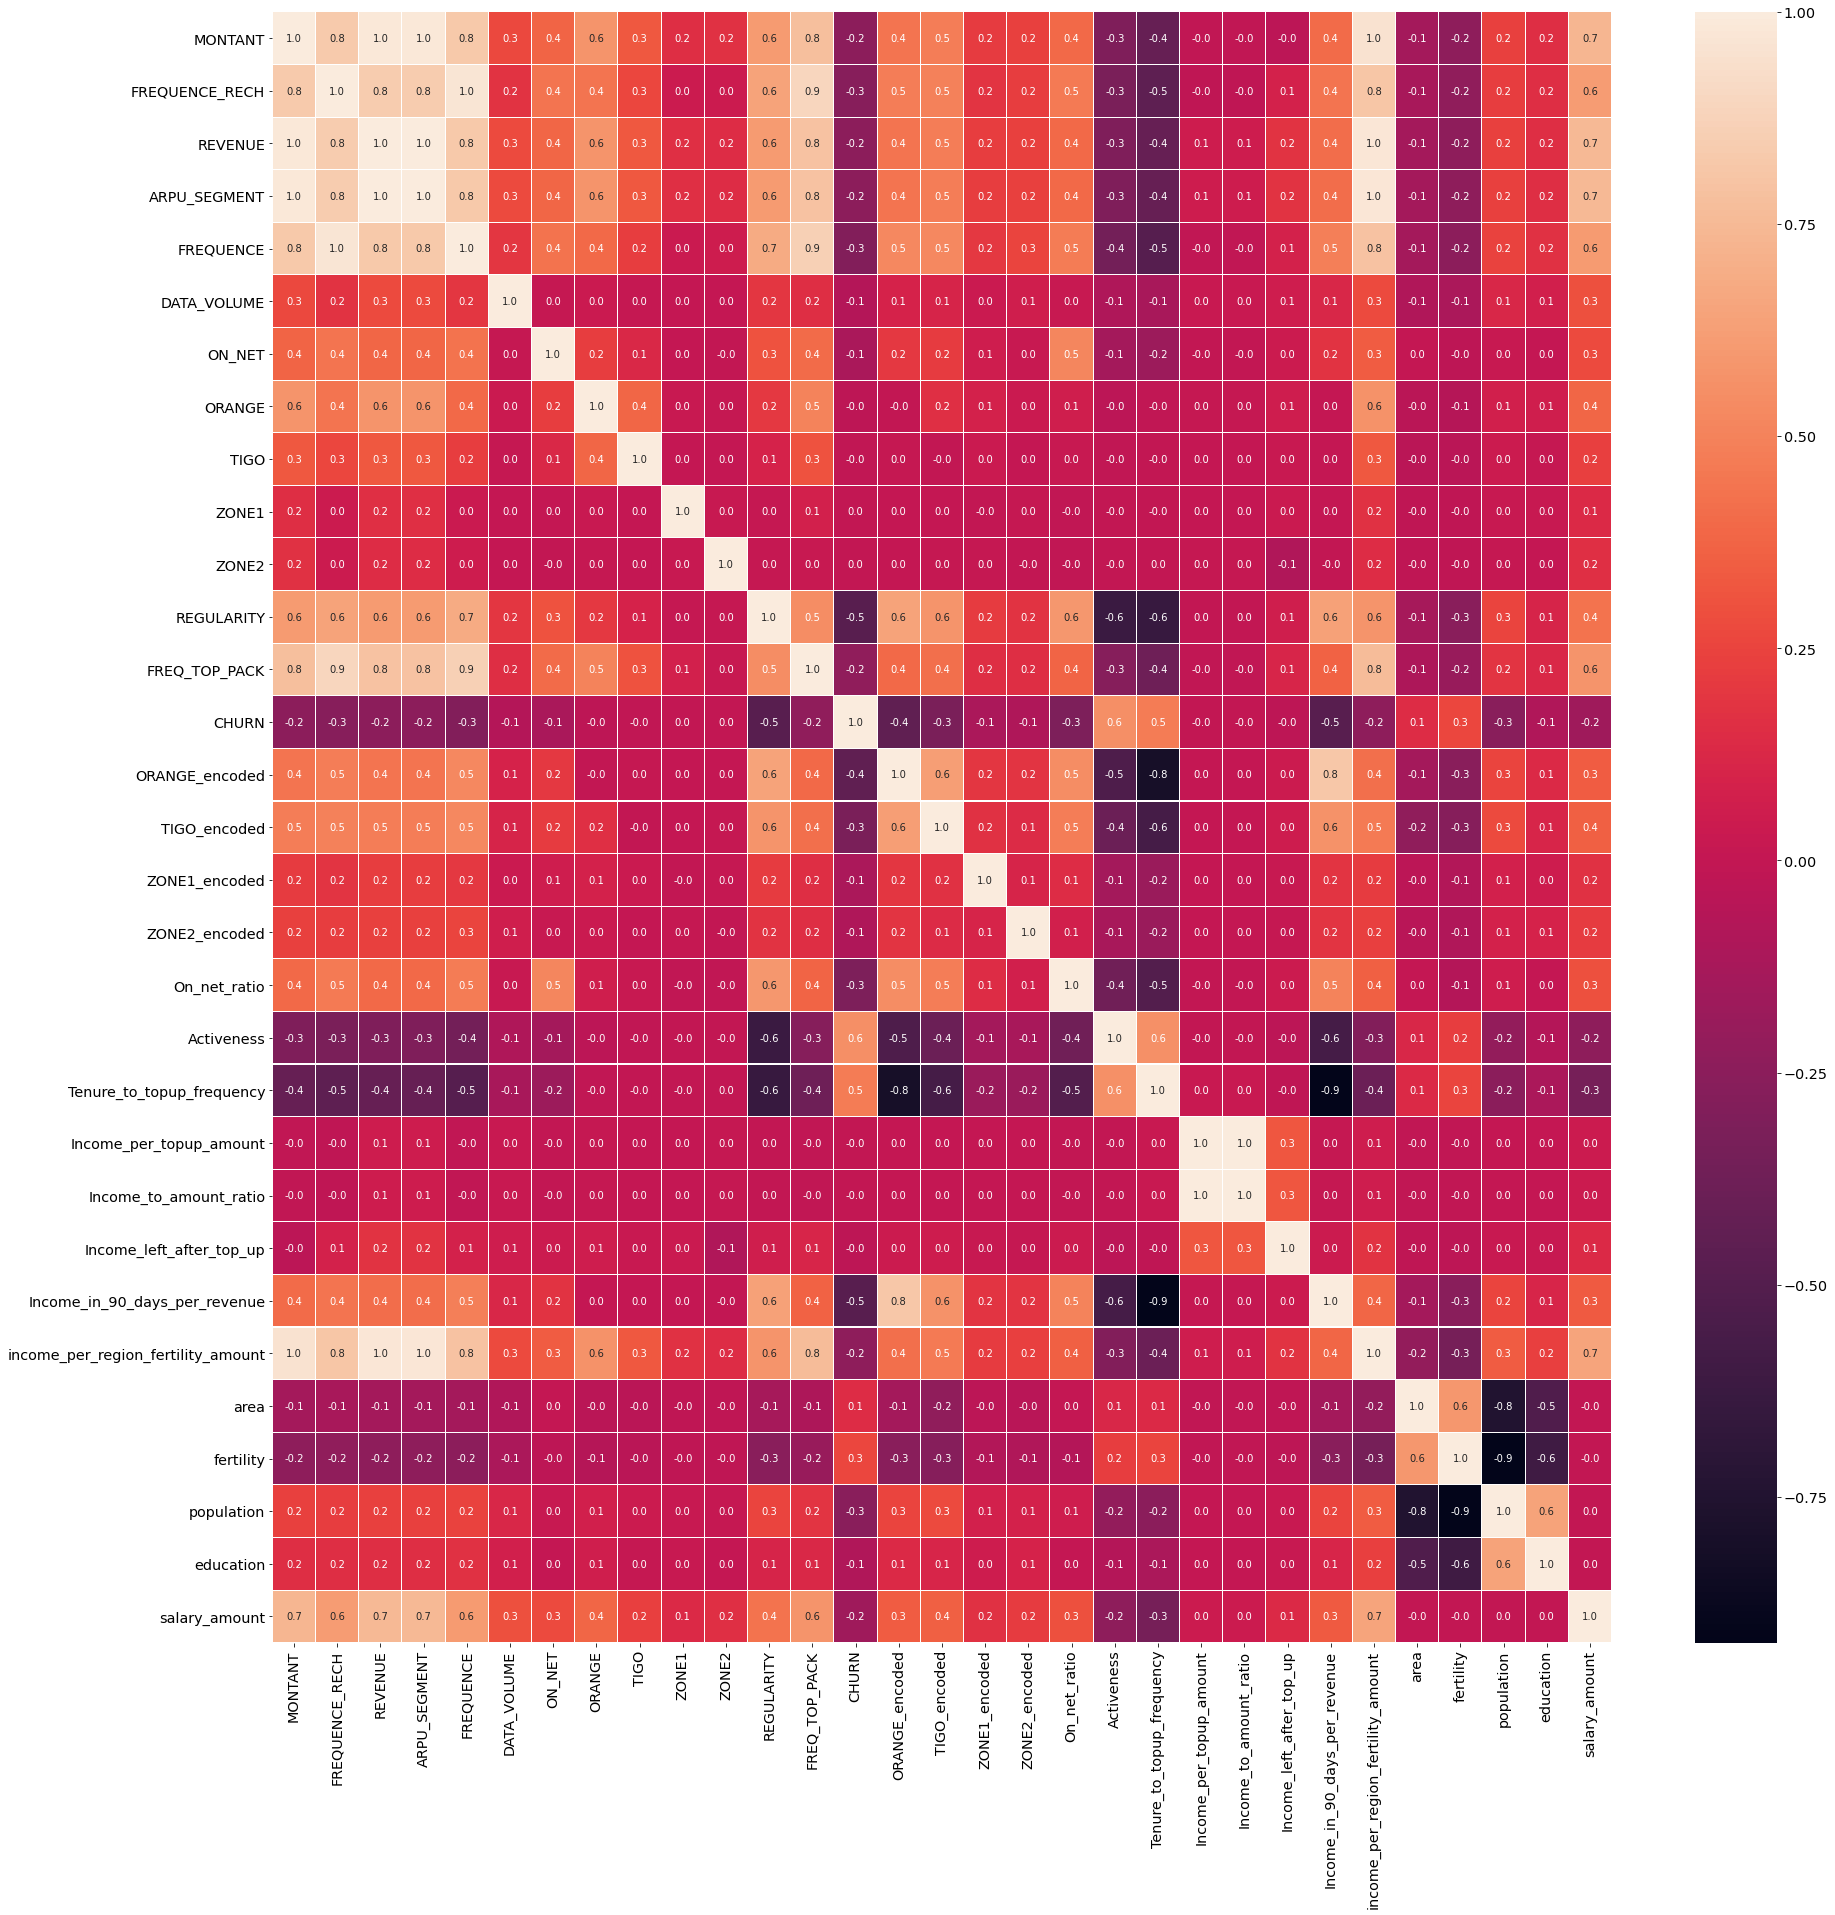

In [20]:
plt.figure(figsize=(30, 30))
sns.heatmap(
    data=data['Train'].corr(),
    annot=True,
    linewidth=0.1,
    fmt='.1f',
);

Now we can see stronger binary dependencies with CHURN

## Build Machine Learning Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

# basic models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [22]:
# define supervised classification task

target = ['CHURN']

Xdf = data['Train'].drop(columns=target)
Y = data['Train'][target]

categorical_features = ['REGION', 'TENURE', 'TOP_PACK', ]
numerical_features = Xdf.columns.difference(categorical_features).tolist()

# resample features
Xdf = Xdf[categorical_features + numerical_features]

In [23]:
# train validation split for checking quality of a model

Xdf_train, Xdf_val, Y_train, Y_val = train_test_split(
    Xdf, Y,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=Y,
)

In [24]:
# let's transform features to machine learning model

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
)

numerical_pipeline = Pipeline(
    [
        ('normalizer', RobustScaler()),
    ]
)

categorical_pipeline = Pipeline(
    [
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)
transforms_linear_models = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_features),
        ('numerical', numerical_pipeline, numerical_features),
    ]
)

transforms_tree_models = ColumnTransformer(
    [
        ('categorical', categorical_pipeline, categorical_features),
    ]
);

In [25]:
Xlm_train = transforms_linear_models.fit_transform(Xdf_train)
Xtree_train = transforms_tree_models.fit_transform(Xdf_train)

Xlm_val = transforms_linear_models.transform(Xdf_val)
Xtree_val = transforms_tree_models.transform(Xdf_val)

In [26]:
# define models

lr = LogisticRegression(
    max_iter=1e3,
    n_jobs=-1,
    random_state=42,
)

knn = KNeighborsClassifier(
    n_jobs=-1,
)

rfc = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    max_depth=15,
    bootstrap=True,
)

In [27]:
#let's fit the models!

lr.fit(Xlm_train, Y_train.values.ravel())
knn.fit(Xtree_train, Y_train.values.ravel())
rfc.fit(Xtree_train, Y_train.values.ravel());

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-27-2b8944f70e1e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(Xtree_train, Y_train);


In [33]:
# let's evaluate the models!

for method, data in zip((lr, rfc), (Xlm_val, Xtree_val)):
    predicted = method.predict(data)
    print(f'Model {method.__class__.__name__}: \
        f1_score: {f1_score(Y_val.values.ravel(), predicted)} \
        roc_auc_score: {roc_auc_score(Y_val.values.ravel(), predicted)}'
    )

Model LogisticRegression:         f1_score: 0.5711423887211616         roc_auc_score: 0.7207717346105748
Model RandomForestClassifier:         f1_score: 0.6711753048983229         roc_auc_score: 0.8415086258526692


## Advanced methods

In [ ]:
import xgboost as xgb

xgbclf = xgb.XGBClassifier(
    n_jobs=-1,
    n_estimators=500,
    use_label_encoder=False,
    objective='binary:logistic',
    max_depth=50,
    learning_rate=0.015,
)

xgbclf.fit(Xtree_train, Y_train.values.ravel())